<a href="https://colab.research.google.com/github/reganmeloche/ML-from-scratch/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic  Regression


This notebook walks through the process of building a logistic regression classifier from scratch. We will discuss the basic idea of logistic regression, as well as dig a little into the more advanced math of gradient descent and the chain rule. We will test our classifier on a couple datasets.

Sources
- https://machinelearningmastery.com/implement-logistic-regression-stochastic-gradient-descent-scratch-python/
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- AI: A modern Approach (Russell and Norvig)
- [Udemy course by Jose Portilla](https://www.udemy.com/course/python-for-data-science-and-machine-learning-bootcamp/) 


## Setup

### Sigmoid Function

**Linear regression** involves simple fitting a line to a set points, which can be used to predict numeric values. But if we have a classification problem (e.g. two values - 0 and 1), then linear regression will not work.

Instead we consider the idea of predicting the *probability* between 0 and 1, and then round the result. We need to transform our curve into something that is bounded between 0 and 1. We use the sigmoid function, and this is the basis of **logistic regression**, which is a machine learning approach to classification.

$$ z =  \frac{\mathrm{1} }{\mathrm{1} + e^{-y} }  $$

If we're dealing with more than 2 classes, then it requires some modification, such as a one-vs-rest scheme.

In [1]:
import math
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    return 1.0 / (1.0 + math.exp(-x))

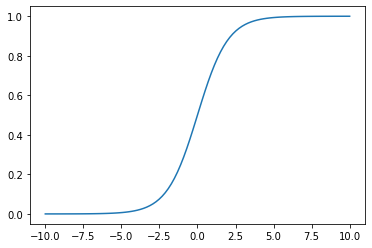

In [3]:
fig = plt.figure()
ax = plt.axes()

x_vec = np.linspace(-10, 10, 100)
y = [sigmoid(x) for x in x_vec]

ax.plot(x_vec, y);

### Prediction

Just as with linear regression, we are using an equation to represent a model.  Input values are combined linearly with weights to get a value. For the simplest case, we have y = mx + b. But with more columns of data, we add more dimensions, e.g. y = c0 + c1x1 + c2x2 + ... + cnxn. Then we plug that into the sigmoid function to smooth it between 0 and 1.

$$ z =  \frac{\mathrm{1} }{\mathrm{1} + e^{-y} }  $$


Below is a sample binary dataset where we try a random set of coefficients. 

In [4]:
# Predicts output value for a row given a set of coefficients
def predict(row, coefficients):
    n = len(row) - 1
    y_hat = coefficients[0] + sum([coefficients[i+1] * row[i] for i in range(n)])
    result = sigmoid(y_hat)
    return round(result, 3)

In [5]:
# test predictions
dataset = [[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]

coeffs = [-0.406605464, 0.852573316, -1.104746259]

result_set = []

for row in dataset:
    y_hat = predict(row, coeffs)
    result_set.append(y_hat)
    print(f'Actual: {row[-1]}, Predicted: {y_hat} ({round(y_hat)})')
    

Actual: 0, Predicted: 0.299 (0)
Actual: 0, Predicted: 0.146 (0)
Actual: 0, Predicted: 0.085 (0)
Actual: 0, Predicted: 0.22 (0)
Actual: 0, Predicted: 0.247 (0)
Actual: 1, Predicted: 0.955 (1)
Actual: 1, Predicted: 0.862 (1)
Actual: 1, Predicted: 0.972 (1)
Actual: 1, Predicted: 0.999 (1)
Actual: 1, Predicted: 0.905 (1)


### Errors

Any time we create a line of best fit for a set of data points, there will be errors. The key to "learning" is that we try to minimize errors. We can think of this as the vertical distance between the predicted value (on the line) and the *actual* value. There are various ways to measure the errors. 



Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors (aka L2):

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

We can define a simple error function to calculate the total error of our previous prediction. Note that we use the probabilistic y_hat value when calculating error (i.e. we don't round to 0 or 1 - we just do that once the model is trained). We will use the L2 error.

In [6]:
def calculate_error(y_hat, y_act):
    return (y_hat - y_act)**2
    
error_sum = 0

for i, y_hat in enumerate(result_set):
    y_act = dataset[i][-1]
    error_sum += calculate_error(y_hat, y_act)

print(f'Total error: {error_sum}')

Total error: 0.25823


### Chain Rule and Gradient Descent

We want to minimize our loss. The way we do this is by updating the coefficients (aka the weights). So how do we know how they are supposed to be updated?

If we calculate the derivative of the loss function with respect to a weight, then we will know how much we should change the weight by in order to minimize it. So to know how much we adjust c0, we need to take the derivative of the loss w.r.t c0. In order to do this, we can apply the **chain rule**.

$$\frac{\partial (y-\hat{y})^2}{\partial c}$$

$$2(y_i - \hat{y}) \cdot \frac{\partial (y-\hat{y})}{\partial c}$$

$$-2(y_i - \hat{y}) \cdot \frac{\partial (\hat{y})}{\partial c}$$

$$-2(y_i - \hat{y}) \cdot \frac{\partial (\hat{y})}{\partial c}$$

At this point, we need to carefully consider y_hat, which is a sigmoid fuction. We can apply a very useful property about the derivative of the sigmoid function (s):

$$ \frac{\partial (s(x))}{\partial x} = s(x) \cdot (1-s(x)) = \hat{y} \cdot (1-\hat{y}) $$

Applying this identity, we get the following (using c1 as example):

$$-2(y - \hat{y}) \cdot \frac{\partial (s(x))}{\partial x} \cdot \frac{\partial (c_0 + c_1x_1 + c_2x_2)}{\partial c_1} $$

$$-2(y - \hat{y}) \cdot  \hat{y} \cdot (1-\hat{y}) \cdot x_1 $$

Since our error $\varepsilon = y - \hat{y}$, we can put all of this together to get:

$$ \alpha \cdot \varepsilon \cdot \hat{y} \cdot (1-\hat{y}) \cdot x_1 $$

Where $ \alpha $ captures any scalars.


This process is known as **Gradient descent**. We are minimizing the loss function by following gradients of the loss function. 

Each training instance is shown to the model one at a time. Model makes a prediction, and then error is calculated, and the model is updated to reduce error for the next prediction. This procedure allows us to find the set of coefficients in a model that result in the smallest error for the model on the training set.

Gradient Descent requires two key parameters
- Learning rate: limits the amount each coefficient is corrected each time it is updated
- Epochs: number of times to run through the training data while updating coefficients.

Coefficients are updated based on the prediction errors. They are updated after every single prediction (rather than aggregating and doing it in a batch) - this is why it's called *stochastic* gradient descent as opposed to *batch* gradient descent, which is an alternative approach.


In [7]:
def stochastic_gradient_descent(training_set, learning_rate, num_epochs, do_print=False):
    # Start with coefficients of 0
    coeff = [0.0 for i in range(len(training_set[0]))]

    # Iterate over the epochs
    for epoch in range(num_epochs):
        sum_error = 0
        for row in training_set:
            y_pred = predict(row, coeff)
            y_act = row[-1]
            error = y_act - y_pred
            
            # Note that the sum is not actually used - just for optional printing
            sum_error += error**2

            # For the first coefficient c0, there is no x value, so just use delta
            delta = learning_rate * error * y_pred * (1 - y_pred)
            coeff[0] = coeff[0] + delta
            for i in range(len(row)-1):
                coeff[i+1] = coeff[i+1] + (delta * row[i])
        
        if do_print: print(f'-> {epoch+1}. error_sum: {round(sum_error,3)}')

    return coeff

In [8]:
learning_rate = 0.3
num_epochs = 20
coef = stochastic_gradient_descent(dataset, learning_rate, num_epochs, do_print=True)
print(f'\nFinal coefficients: {coef}')

-> 1. error_sum: 2.216
-> 2. error_sum: 1.613
-> 3. error_sum: 1.115
-> 4. error_sum: 0.826
-> 5. error_sum: 0.623
-> 6. error_sum: 0.494
-> 7. error_sum: 0.412
-> 8. error_sum: 0.353
-> 9. error_sum: 0.31
-> 10. error_sum: 0.275
-> 11. error_sum: 0.247
-> 12. error_sum: 0.224
-> 13. error_sum: 0.205
-> 14. error_sum: 0.189
-> 15. error_sum: 0.174
-> 16. error_sum: 0.162
-> 17. error_sum: 0.151
-> 18. error_sum: 0.142
-> 19. error_sum: 0.134
-> 20. error_sum: 0.126

Final coefficients: [-0.5480174390999997, 1.0472000844995306, -1.4576797654954183]


## Logistic Regression Class

Now we can combine all of this functionality into the logistic regression classifier. It may be preferable to define the helper functions (predict, sigmoid, sgd) *inside* the class instead of outside.



In [9]:
class MyLogisticRegression:
    def __init__(self, learning_rate = 0.3, num_epochs = 20):
        self._coeffs = []
        self._learning_rate = learning_rate
        self._num_epochs = num_epochs
    
    def fit(self, X, y):
        dataset = np.concatenate((X, np.transpose([y])), axis=1)
        self._coeffs = stochastic_gradient_descent(dataset, self._learning_rate, self._num_epochs)

    def predict(self, X):
        fake_y =  np.zeros(len(X))
        new_x = np.concatenate((X, np.transpose([fake_y])), axis = 1)
        preds = []
        for x in new_x:
            next_pred = predict(x, self._coeffs)
            preds.append(round(next_pred))
        return preds

### Test Execution

In [10]:
learning_rate = 0.3
num_epochs = 50
my_lr = MyLogisticRegression(learning_rate, num_epochs)

X = [r[:-1] for r in dataset]
y = [r[-1] for r in dataset]

my_lr.fit(X,y)

test_val = [7.6, 2.1]
preds = my_lr.predict([test_val])

print(preds)

[1]


## Evaluation and Comparison

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [16]:
ROOT_PATH = '/content/drive/MyDrive/Tech/ML/datasets'

### Diabetes

[Kaggle Link](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

From Kaggle description: This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

In [17]:
# Import data
filename = 'diabetes.txt'

columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'target']
df = pd.read_csv(f'{ROOT_PATH}/{filename}', header=None, names=columns)
df.head()

,a,b,c,d,e,f,g,h,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [18]:
X = df.loc[:, df.columns != 'target'].values
y = df['target'].values

### Titanic

[Kaggle Link](https://www.kaggle.com/competitions/titanic/data)

We can use this dataset to predict if someone survived the Titanic. Some of the data includes the class of the passenger, sex, age, ticket fare, etc. There are separate datasets for train and test, but to keep things consistent, we will just merge them together and split them later on.


In [ ]:
# Import data
train_filename = 'titanic_train.csv'
test_filename = 'titanic_test.csv'

train_df = pd.read_csv(f'{ROOT_PATH}/{train_filename}')
test_df = pd.read_csv(f'{ROOT_PATH}/{train_filename}')
df = pd.concat([train_df, test_df])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Impute the age based on the PClas
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [ ]:
# Clean data

# Select desired columns
df2 = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]

# Impute the age based on the class
df2['Age'] = df2[['Age','Pclass']].apply(impute_age,axis=1)

# Drop nulls
df3 = df2.dropna()

# Get dummies
df4 = pd.get_dummies(df3, columns=['Sex', 'Embarked'], drop_first=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
X = df4.loc[:, df4.columns != 'Survived'].values
y = df4['Survived'].values

### Execution

In [19]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
my_lr = MyLogisticRegression(learning_rate=0.3, num_epochs=100)

my_lr.fit(X_train, y_train)

preds = my_lr.predict(X_test)

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       122
           1       0.66      0.70      0.68        70

    accuracy                           0.76       192
   macro avg       0.74      0.75      0.74       192
weighted avg       0.76      0.76      0.76       192



In [22]:
lr = LogisticRegression(max_iter=100)

lr.fit(X_train, y_train)

preds2 = lr.predict(X_test)

print(metrics.classification_report(y_test, preds2))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       122
           1       0.73      0.57      0.64        70

    accuracy                           0.77       192
   macro avg       0.75      0.72      0.73       192
weighted avg       0.76      0.77      0.76       192

